This model is a Smile Classifier.

Importing packages and loading dataset

In [ ]:
!pip install scikeras
!pip install tensorflow


In [ ]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import img_to_array

from keras.utils import to_categorical
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import tensorflow as tf
import imghdr
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from zipfile import ZipFile

In [ ]:
#with ZipFile('/content/drive/MyDrive/Colab Notebooks/SMILES .zip') as zipObj:
 # zipObj.extractall('/content/drive/MyDrive/Colab Notebooks/dataFile')

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dataFile/SMILES'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)

    # Check if the current item is a directory
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)

            # Check if the current item is a file
            if os.path.isfile(image_path):
                try:
                    img = cv2.imread(image_path)
                    tip = imghdr.what(image_path)
                    if tip not in image_exts:
                        print('Image not in ext list {}'.format(image_path))
                        os.remove(image_path)
                except Exception as e:
                    print('Issue with image {}: {}'.format(image_path, str(e)))

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/dataFile/SMILES',color_mode = "grayscale",batch_size=1000)

Found 7650 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
len(batch[0])

1000

Data Preprocessing

Scaling

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
len(batch[0])

1000

In [ ]:
X,y = batch
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [ ]:
batch[0].shape

(1000, 256, 256, 1)

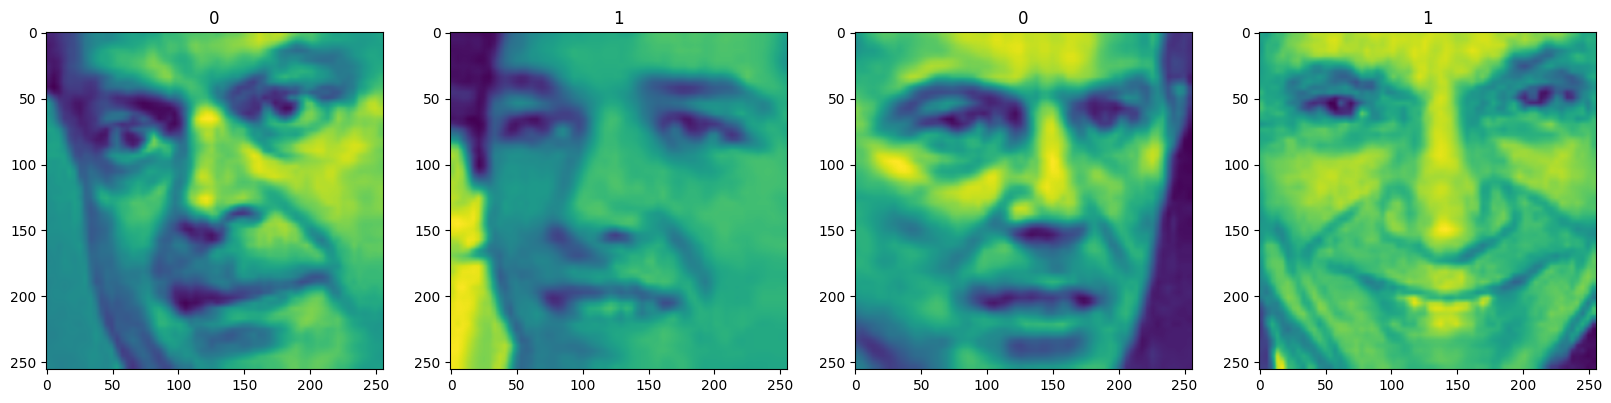

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

From this we see that 0 = no smile(negative) and 1 = smile(positive)

## Building Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import layers, models

In [ ]:
model1 = models.Sequential()

model1.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for Dense layers
model1.add(layers.Flatten())

# Dense layers with reduced units
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))  # Adding dropout for regularization

model1.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
hist = model1.fit(X_train, y_train, epochs=50, batch_size= 50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
16/16 [==============================] - 15s 84ms/step - loss: 0.7227 - accuracy: 0.4712 - val_loss: 0.6920 - val_accuracy: 0.5150
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.6933 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5150
Epoch 3/50
16/16 [==============================] - 1s 56ms/step - loss: 0.6896 - accuracy: 0.5487 - val_loss: 0.6868 - val_accuracy: 0.5100
Epoch 4/50
16/16 [==============================] - 1s 47ms/step - loss: 0.6597 - accuracy: 0.6400 - val_loss: 0.6003 - val_accuracy: 0.7950
Epoch 5/50
16/16 [==============================] - 1s 47ms/step - loss: 0.5568 - accuracy: 0.7212 - val_loss: 0.4798 - val_accuracy: 0.7450
Epoch 6/50
16/16 [==============================] - 1s 47ms/step - loss: 0.4701 - accuracy: 0.7750 - val_loss: 0.4770 - val_accuracy: 0.7700
Epoch 7/50
16/16 [==============================] - 1s 47ms/step - loss: 0.5027 - accuracy: 0.7675 - val_loss: 0.5237 - val_accuracy: 0.7300
Epoch 8/50
1

In [ ]:

h5_filename = '/content/drive/My Drive/Colab Notebooks/Final_model.h5'
model1.save(h5_filename)

loss graph

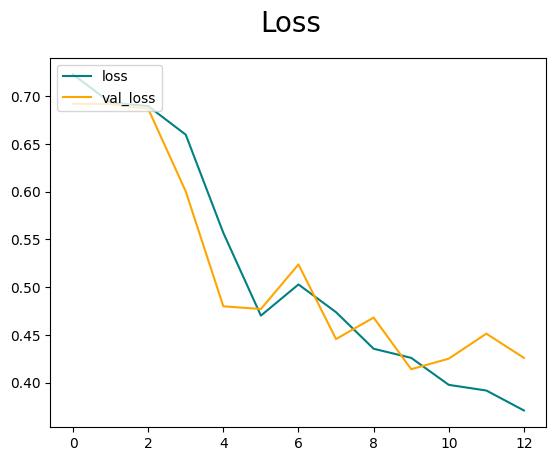

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Accuracy graph

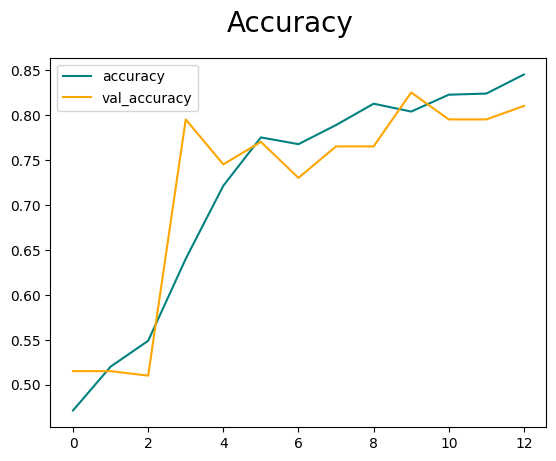

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
yhat.shape

(200, 1)

In [ ]:
yhat = model1.predict(X_test)
precision.update_state(y_test, yhat)
recall.update_state(y_test, yhat)
accuracy.update_state(y_test, yhat)

7/7 [==============================] - 0s 23ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=200.0>

In [ ]:
#for batch in test.as_numpy_iterator():
 #   X, y = batch
   # yhat = model.predict(X)
   # precision.update_state(y, yhat)
    #recall.update_state(y, yhat)
    #accuracy.update_state(y, yhat)

In [ ]:
print(precision.result())
print(recall.result())
print(accuracy.result())

tf.Tensor(0.82417583, shape=(), dtype=float32)
tf.Tensor(0.77319586, shape=(), dtype=float32)
tf.Tensor(0.81, shape=(), dtype=float32)


Evaluations

## Using a pretrained model as my image classifier: VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
model_vgg16 = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 22s 0us/step


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
base_model = VGG16(include_top=False, weights=None, input_shape=(256, 256 , 1))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile your model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
hist = model.fit(X_train, y_train, epochs=10, batch_size= 50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
16/16 [==============================] - 39s 960ms/step - loss: 0.7096 - accuracy: 0.4975 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 2/10
16/16 [==============================] - 14s 896ms/step - loss: 0.6935 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5150
Epoch 3/10
16/16 [==============================] - 14s 886ms/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5150
Epoch 4/10
16/16 [==============================] - 14s 896ms/step - loss: 0.6934 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5150


In [ ]:
test = model.predict(X_train)


25/25 [==============================] - 7s 142ms/step


In [ ]:
precision2 = Precision()
recall2 = Recall()
accuracy2 = BinaryAccuracy()

In [ ]:
yhat = model.predict(X_test)
accuracy2.update_state(y_test, yhat)

7/7 [==============================] - 1s 158ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=400.0>

In [ ]:

print(accuracy2.result())

tf.Tensor(0.515, shape=(), dtype=float32)


## Using VGG16 as a feature extractor and making a model to do the classification

In [ ]:
outputs = base_model.get_layer("block5_pool").output
feature_extractor = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
train = feature_extractor.predict(X_train)
train.shape

25/25 [==============================] - 4s 131ms/step


(800, 8, 8, 512)

In [ ]:
test = base_model.predict(X_test)
test.shape

7/7 [==============================] - 1s 143ms/step


(200, 8, 8, 512)

In [ ]:
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [ ]:

model1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
hist = model1.fit(X_train, y_train, epochs=10, batch_size= 50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
16/16 [==============================] - 4s 87ms/step - loss: 0.6959 - accuracy: 0.5312 - val_loss: 0.6785 - val_accuracy: 0.5350
Epoch 2/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6640 - accuracy: 0.5938 - val_loss: 0.6416 - val_accuracy: 0.7400
Epoch 3/10
16/16 [==============================] - 1s 53ms/step - loss: 0.5947 - accuracy: 0.7050 - val_loss: 0.5287 - val_accuracy: 0.7550
Epoch 4/10
16/16 [==============================] - 1s 55ms/step - loss: 0.4889 - accuracy: 0.7837 - val_loss: 0.4915 - val_accuracy: 0.7200
Epoch 5/10
16/16 [==============================] - 1s 50ms/step - loss: 0.4213 - accuracy: 0.8138 - val_loss: 0.4673 - val_accuracy: 0.7700
Epoch 6/10
16/16 [==============================] - 1s 49ms/step - loss: 0.4046 - accuracy: 0.8238 - val_loss: 0.4572 - val_accuracy: 0.7750
Epoch 7/10
16/16 [==============================] - 1s 48ms/step - loss: 0.3714 - accuracy: 0.8338 - val_loss: 0.4749 - val_accuracy: 0.7550
Epoch 8/10
16

In [ ]:
yhat = model1.predict(X_test)
precision2.update_state(y_test, yhat)
recall2.update_state(y_test, yhat)
accuracy2.update_state(y_test, yhat)

7/7 [==============================] - 0s 11ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=400.0>

In [ ]:
print(precision2.result())
print(recall2.result())
print(accuracy2.result())

tf.Tensor(0.7117117, shape=(), dtype=float32)
tf.Tensor(0.4247312, shape=(), dtype=float32)
tf.Tensor(0.6525, shape=(), dtype=float32)
